In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

%matplotlib inline

In [2]:
def get_data(name):
    train_name = name+'_train_new.csv'
    test_name = 'test_'+name+'_round2.csv'
    train_data_path = os.path.join(path, train_name)
    test_data_path = os.path.join(path, test_name)
    train_data = pd.read_csv('../'+train_data_path)
    test_data = pd.read_csv('../'+test_data_path)
    train_data = pd.concat([train_data, test_data], axis=0, ignore_index=True, sort=False)
    if name=='tag':
        train_data.loc[train_data['Tag']==0.5, 'Tag']=-1
        train_data['Tag'] = train_data['Tag'].astype(int)
    return train_data

In [3]:
path = os.path.join(os.path.dirname('__file__'),'data')

operation_data = get_data(name='operation')
transaction_data = get_data(name='transaction')
tag = get_data(name='tag')

print(operation_data.shape)
print(transaction_data.shape)
print(tag.shape)

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(2601421, 20)
(393036, 27)
(62767, 2)


In [4]:
tr_data = pd.merge(transaction_data, tag, on='UID', how='left')
trans_delete = ['code1', 'code2']
tr_data = tr_data.drop(trans_delete, axis=1)
print(tr_data.shape)

(393036, 26)


In [5]:
train_data = tr_data[tr_data['Tag']!=-1]
test_data = tr_data[tr_data['Tag']==-1]

In [6]:
col = 'merchant'
tmp_train = train_data.groupby(['UID',col])['Tag'].agg({col+'_count':'mean'}).reset_index()
tmp_return = tmp_train.groupby([col])['UID'].agg({col+'_UID_count':'nunique'}).reset_index()
tmp_train = tmp_train.groupby([col])[col+'_count'].agg({col+'_crt':'mean'}).reset_index()
tmp_day = train_data.groupby([col])['day'].agg({col+'_day_nunique':'nunique', col+'_day_std':'std'}).reset_index()
tmp_day = tmp_day.merge(tmp_train, on=col, how='left')
tmp_return = tmp_return.merge(tmp_train, on=col, how='left')
tmp_return = tmp_return[tmp_return[col+'_UID_count']>20]
tmp_return = tmp_return[tmp_return[col+'_crt']>0.5]
tmp_return = tmp_return[tmp_return[col+'_crt']<1]
trains_rule2 = tmp_return[['merchant', 'merchant_crt']]
print(tmp_return)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


               merchant  merchant_UID_count  merchant_crt
151    01ecb3fa2bfc7f48                  29      0.827586
986    0d9ffabe9791dae0                  23      0.782609
2225   1d1a3a44c64c54bc                  21      0.857143
2245   1d70c9a7b3b11c39                 260      0.823077
2505   204689d96577cade                  22      0.818182
3126   2873fd07e8ea58d5                  32      0.937500
3603   2f309b871b04d75a                  26      0.923077
3902   32ca26f1e957f3cd                  29      0.965517
3952   33668ca4b2df0d6f                  45      0.933333
4535   3b7add8730fc6b5a                 141      0.978723
6926   5a4d6e9ecca8af47                  24      0.958333
7907   669aa302f404c76f                  33      0.939394
9181   77dc88f9aababf9c                  24      0.958333
12651  a602603508f197f5                  21      0.809524
13100  abc6bc660561e0eb                 110      0.872727
13234  ad5820d3d465893d                 133      0.879699
15011  c32b190

In [7]:
len(trains_rule2)

25

In [8]:
c_merchant_train = trains_rule2
c_merchant_train.shape

(25, 2)

In [9]:
ctr = [0.35, 0.77, 0.82]

In [10]:
c_merchant_test = pd.DataFrame([ 'c71c876b8979028e', 'fafb0e565bc51007', 'e12586541e5f30b7'])

In [11]:
c_merchant_test = c_merchant_test.rename(columns={0:'merchant'})

In [12]:
c_merchant_test['merchant_crt'] = ctr
c_merchant_test.shape

(3, 2)

In [13]:
c_merchant_test

,merchant,merchant_crt
0,c71c876b8979028e,0.35
1,fafb0e565bc51007,0.77
2,e12586541e5f30b7,0.82


In [14]:
c_data_train = pd.DataFrame(train_data[train_data['merchant'].isin(c_merchant_train.merchant)])
c_data_test = pd.DataFrame(test_data[test_data['merchant'].isin(c_merchant_test.merchant)])

In [15]:
c_merchant = pd.concat([c_merchant_train, c_merchant_test])

In [16]:
c_data = pd.concat([c_data_train, c_data_test])

In [17]:
c_data = c_data.merge(c_merchant, on='merchant', how='left')

In [18]:
def give_crt(items):
    mer = items['merchant']
    day= items['day']
    if mer=='c71c876b8979028e' and day==3:
        return 0.94
    else:
        return items['merchant_crt']
c_data['merchant_crt'] = c_data.apply(give_crt, axis=1)

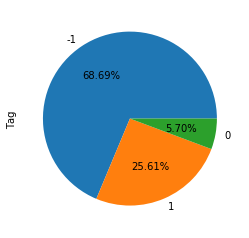

In [19]:
c_data['Tag'].value_counts().plot.pie(autopct = '%1.2f%%')

In [20]:
c_data.loc[c_data['device_code1'].isnull(),'device_code1'] = c_data[c_data['device_code1'].isnull()]['device_code2']
c_data.loc[c_data['device_code1'].isnull(),'device_code1'] = c_data[c_data['device_code1'].isnull()]['device_code3']
c_data = c_data.drop(['device_code2','device_code3'],axis=1)

In [21]:
c_data = c_data.drop(['acc_id2'],axis=1)

In [22]:
c_data['isnull_num'] = c_data.apply(lambda x: x.isnull().sum(),axis=1)

In [23]:
cols_f = ['amt_src1', 'trans_type1','amt_src2','geo_code','ip1_sub','mac1','merchant','acc_id3','channel','market_type','trans_type2','market_code','ip1','device1','device_code1','acc_id1','device2']
for col in cols_f:
    c_data[col] = pd.factorize(c_data[col])[0]
c_data.head()

,UID,channel,day,time,trans_amt,amt_src1,merchant,trans_type1,acc_id1,device_code1,...,amt_src2,acc_id3,geo_code,trans_type2,market_code,market_type,ip1_sub,Tag,merchant_crt,isnull_num
0,19092,0,30,11:48:47,1459,0,0,0,0,0,...,0,-1,0,0,0,0,0,0,0.872727,1
1,13793,0,22,15:11:16,3905,1,0,1,1,1,...,0,-1,1,0,-1,-1,1,0,0.872727,3
2,21655,1,8,15:34:20,2818,2,1,2,-1,2,...,1,-1,2,1,1,1,2,1,0.939394,3
3,18494,0,8,18:58:23,216,0,2,0,2,3,...,0,-1,-1,0,2,0,3,0,0.879699,3
4,13949,1,1,11:59:00,2818,3,3,2,-1,4,...,-1,-1,2,1,-1,-1,4,0,0.937500,6


In [24]:
from datetime import datetime
c_data['hour'] = c_data.time.str[0:2].astype(int)

c_data['time'] = pd.to_datetime(c_data['time'])
c_data['time'] = c_data['time'].apply(lambda x:(x-datetime.now()).seconds/3600)

c_data.head()

,UID,channel,day,time,trans_amt,amt_src1,merchant,trans_type1,acc_id1,device_code1,...,acc_id3,geo_code,trans_type2,market_code,market_type,ip1_sub,Tag,merchant_crt,isnull_num,hour
0,19092,0,30,12.110833,1459,0,0,0,0,0,...,-1,0,0,0,0,0,0,0.872727,1,11
1,13793,0,22,15.485556,3905,1,0,1,1,1,...,-1,1,0,-1,-1,1,0,0.872727,3,15
2,21655,1,8,15.870000,2818,2,1,2,-1,2,...,-1,2,1,1,1,2,1,0.939394,3,15
3,18494,0,8,19.270833,216,0,2,0,2,3,...,-1,-1,0,2,0,3,0,0.879699,3,18
4,13949,1,1,12.281111,2818,3,3,2,-1,4,...,-1,2,1,-1,-1,4,0,0.937500,6,11


In [25]:
train = c_data[c_data['Tag']!=-1]
test = c_data[c_data['Tag']==-1]
print(train.shape)
print(test.shape)

(3066, 26)
(6727, 26)


In [26]:
train_y = pd.DataFrame()
train_y['UID'] = train.UID.unique()
train_y.shape

(942, 1)

In [27]:
Tag = c_data[['UID','Tag']]
train_y = train_y.merge(Tag.groupby(['UID'])['Tag'].agg({'Tag':lambda x: x.value_counts().index[0]}).reset_index(),on='UID',how='left')
train_y.shape

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app


(942, 2)

In [28]:
test_y = pd.DataFrame()
test_y['UID'] = test.UID.unique()
test_y.shape

(1921, 1)

In [29]:
Tag = c_data[['UID','Tag']]
test_y = test_y.merge(Tag.groupby(['UID'])['Tag'].agg({'Tag':lambda x: x.value_counts().index[0]}).reset_index(),on='UID',how='left')
test_y.shape

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app


(1921, 2)

In [30]:
#类别型变量
def get_category_feature(data_set,feature,train_y):
    
    #train_y = train_y.merge(data_set.groupby(['UID'])[feature].agg(lambda x: x.value_counts().index[0]).reset_index(),on='UID',how='left')

    train_y = train_y.merge(data_set.groupby(['UID'])[feature].agg({feature+'_here_nunique':'nunique'}).reset_index(),on='UID',how='left')

    return train_y

In [31]:
#数值型变量
def get_numerical_feature(data_set,feature,train_y):
    
    agg_dict = {feature+'_here_sum':'sum', feature+'_here_mean':'mean', feature+'_here_var':'var', 
                feature+'_here_min':'min', feature+'_here_max':'max', feature+'_here_std':'std',
               feature+'_here_mad':'mad',feature+'_here_skew':'skew'}
    train_y = train_y.merge(data_set.groupby(['UID'])[feature].agg(agg_dict).reset_index(),on='UID',how='left')

    return train_y

In [32]:
cols = ['channel', 'day', 'amt_src1', 'merchant', 'trans_type1', 'acc_id1', 'device_code1', 'device1',
       'device2', 'mac1', 'ip1', 'amt_src2', 'geo_code', 'trans_type2', 'ip1_sub', 'hour']
for col in cols:
    print(col)
    train_y = get_category_feature(train, col, train_y)
print(train_y.shape)  

channel
day
amt_src1
merchant
trans_type1
acc_id1
device_code1
device1
device2
mac1
ip1


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


amt_src2
geo_code
trans_type2
ip1_sub
hour
(942, 18)


In [33]:
cols = ['time', 'trans_amt', 'bal', 'isnull_num']
for col in cols:
    print(col)
    train_y = get_numerical_feature(train, col, train_y)
print(train_y.shape)

time


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


trans_amt
bal
isnull_num
(942, 50)


In [34]:
cols = ['channel', 'day', 'amt_src1', 'merchant', 'trans_type1', 'acc_id1', 'device_code1', 'device1',
       'device2', 'mac1', 'ip1', 'amt_src2', 'geo_code', 'trans_type2', 'ip1_sub', 'hour']
for col in cols:
    print(col)
    test_y = get_category_feature(test, col, test_y)
print(test_y.shape)  

channel
day
amt_src1
merchant
trans_type1
acc_id1
device_code1
device1
device2
mac1
ip1
amt_src2
geo_code


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


trans_type2
ip1_sub
hour
(1921, 18)


In [35]:
cols = ['time', 'trans_amt', 'bal', 'isnull_num']
for col in cols:
    print(col)
    test_y = get_numerical_feature(test, col, test_y)
print(test_y.shape)

time


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


trans_amt
bal
isnull_num
(1921, 50)


In [36]:
def get_mercant_feature(data_set, train_y):
    tmp = data_set.groupby(['merchant'])['UID'].agg({'merchant_UID_nunique':'nunique'})
    tmp = data_set.merge(tmp, on='merchant', how='left')
    tmp = tmp.groupby(['UID'])['merchant_UID_nunique'].agg({'merchant_UID_nunique_max':'max', 'merchant_UID_nunique_mim':'min','merchant_UID_nunique_mean':'mean'}).reset_index()
    train_y = train_y.merge(tmp, on='UID', how='left')
    return train_y
train_y = get_mercant_feature(train, train_y)
test_y = get_mercant_feature(test, test_y)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [37]:
train_y.shape

(942, 53)

In [38]:
train_y['Tag'].sum()/len(train_y)

0.8779193205944799

In [39]:
##统计次数,day,merchant信息
def get_day_feature(data_set, train_y):
    tmp = data_set.groupby(['UID', 'merchant'])['day'].agg({'day':'mean'}).reset_index()
    tmp_merchant_day = tmp.groupby(['merchant', 'day'])['UID'].agg({'count':'count'}).reset_index()
    tmp_merchant = tmp.groupby(['merchant'])['UID'].agg({'all_count':'count'}).reset_index()
    tmp_merchant_day = tmp_merchant_day.merge(tmp_merchant, on='merchant', how='left')
    tmp_merchant_day['day_ratio'] = tmp_merchant_day['count']/tmp_merchant_day['all_count']
    tmp = tmp.merge(tmp_merchant_day, on=['merchant', 'day'], how='left')
    tmp = tmp.groupby(['UID'])['day_ratio'].agg({'ratio_mean':'mean', 'ratio_max':'max', 'ratio_min':'min'}).reset_index()
    train_y = train_y.merge(tmp, on='UID', how='left')
    return train_y

In [40]:
def get_day_merchant_features(data_set, train_y):
    tmp = data_set.groupby(['UID', 'merchant'])['day'].agg({'merchant_count':'count'}).reset_index()
    tmp = tmp.groupby(['UID'])['merchant_count'].agg({'merchant_count_mean':'mean', 'merchant_count_max':'max', 'merchant_count_min':'min'}).reset_index()
    train_y = train_y.merge(tmp, on='UID', how='left')
    return train_y

In [41]:
train_y = get_day_feature(train, train_y)
test_y = get_day_feature(test, test_y)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [42]:
train_y = get_day_merchant_features(train, train_y)
test_y = get_day_merchant_features(test, test_y)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


In [43]:
def get_ctr_features(data_set, train_y):
    agg_dict = {'merchant_ctr_max':'max', 'merchant_ctr_mean':'mean', 'merchant_ctr_min':'min', 'merchant_ctr_std':'std', 'merchant_ctr_sum':'sum'}
    train_y = train_y.merge(data_set.groupby(['UID'])['merchant_crt'].agg(agg_dict).reset_index(),on='UID',how='left')
    return train_y

In [44]:
train_y = get_ctr_features(train, train_y)
test_y = get_ctr_features(test, test_y)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


In [45]:
test_y['UID'].nunique()

1921

In [46]:
all_features = pd.read_csv('../data/tag_data_baseline.csv')

In [47]:
op_nunique_features = [i for i in all_features.columns if 'op_nunique' in i]

In [48]:
trans_nunique_features = [i for i in all_features.columns if 'trans_nunique' in i]

In [49]:
isnull_features = [i for i in all_features.columns if 'isnull' in i]

In [50]:
time_features = ['op_time_abnor_nunique', 'op_time_abnor_count', 'trans_time_abnor_nunique', 'trans_time_abnor_count']

In [51]:
UID_features = [i for i in all_features.columns if '_UID_sum' in i]

In [52]:
base = ['UID']

In [53]:
merge_features = base + op_nunique_features + trans_nunique_features + isnull_features + time_features + UID_features

In [54]:
len(merge_features)

89

In [55]:
merge_data = all_features[merge_features]

In [56]:
train_y = train_y.merge(merge_data, on='UID', how='left')
test_y = test_y.merge(merge_data, on='UID', how='left')
print(train_y.shape)
print(test_y.shape)

(942, 152)
(1921, 152)


In [57]:
X_tr = train_y.drop(['Tag', 'merchant_UID_nunique_max', 'merchant_UID_nunique_mim', 'merchant_UID_nunique_mean'],axis = 1)
y_tr = train_y['Tag']

test_id = test_y['UID']
X_test = test_y.drop(['Tag', 'merchant_UID_nunique_max', 'merchant_UID_nunique_mim', 'merchant_UID_nunique_mean'],axis = 1)

print(X_tr.shape)
print(y_tr.shape)
print(X_test.shape)

(942, 148)
(942,)
(1921, 148)


In [58]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [59]:
def tpr_weight_funtion(y_true,y_predict):
    d = pd.DataFrame()
    d['prob'] = list(y_predict)
    d['y'] = list(y_true)
    d = d.sort_values(['prob'], ascending=[0])
    y = d.y
    PosAll = pd.Series(y).value_counts()[1]
    NegAll = pd.Series(y).value_counts()[0]
    pCumsum = d['y'].cumsum()
    nCumsum = np.arange(len(y)) - pCumsum + 1
    pCumsumPer = pCumsum / PosAll
    nCumsumPer = nCumsum / NegAll
    TR1 = pCumsumPer[abs(nCumsumPer-0.001).idxmin()]
    TR2 = pCumsumPer[abs(nCumsumPer-0.005).idxmin()]
    TR3 = pCumsumPer[abs(nCumsumPer-0.01).idxmin()]
    return 0.4 * TR1 + 0.3 * TR2 + 0.3 * TR3

In [60]:
X_train,X_val,y_train,y_val= train_test_split(X_tr,y_tr,test_size=0.2,random_state=2)

In [61]:
gbm = XGBClassifier( n_estimators= 50, max_depth= 2, min_child_weight= 2, gamma=0.9, subsample=0.9, 
                        colsample_bytree=0.8, objective= 'binary:logistic', nthread= -1, scale_pos_weight=1).fit(X_train, y_train)

In [62]:
ypred = gbm.predict_proba(X_val)

In [63]:
X_val.shape

(189, 148)

In [64]:
score = tpr_weight_funtion(y_val, ypred[:,1])
print('score:',score)

score: 0.005952380952380952


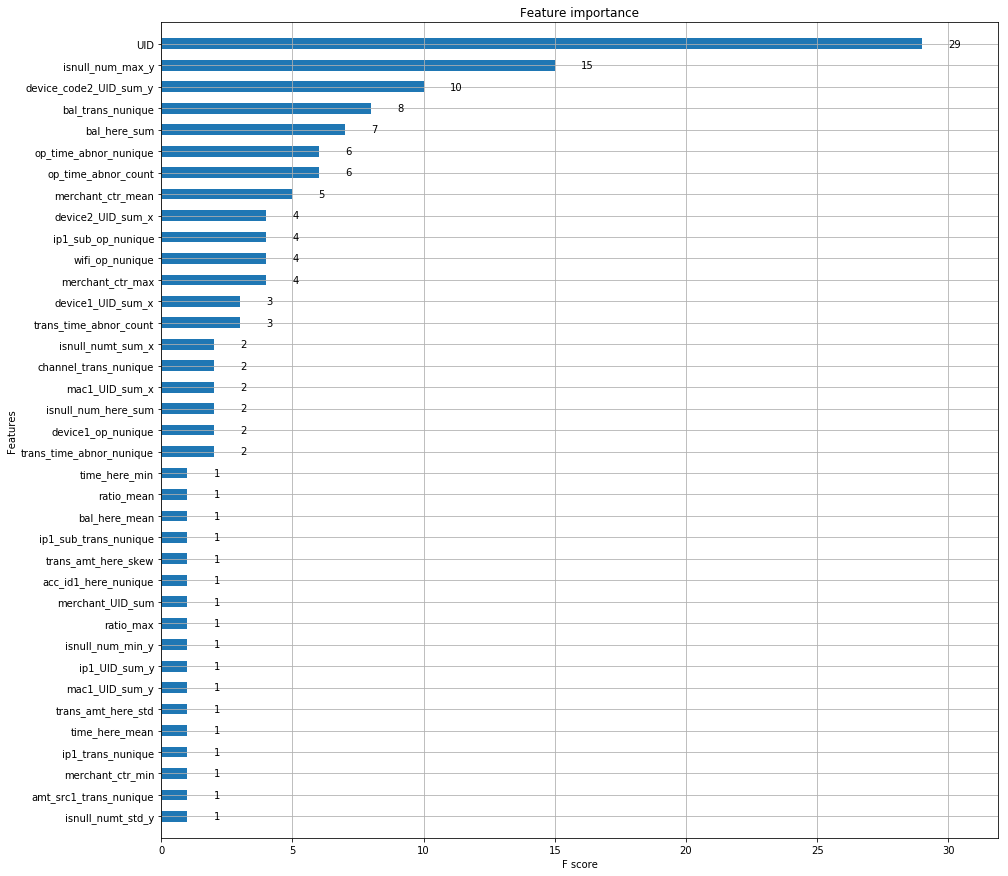

In [65]:
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(gbm,height=0.5,ax=ax, max_num_features=64)

In [66]:
preds = gbm.predict_proba(X_test)

In [67]:
preds[:,1]

array([0.8424707 , 0.7286481 , 0.7123545 , ..., 0.9249732 , 0.53743595,
       0.950194  ], dtype=float32)

In [68]:
sub = pd.DataFrame()
sub['UID'] = test_y['UID']
sub['preds'] = preds[:,1]

In [70]:
test_tag = pd.read_csv('../result/ensemble.csv')

In [71]:
pred_data = pd.merge(test_tag,sub,on='UID', how='left')
pred_data.shape

(31588, 3)

In [72]:
pred_data['Tag'][(pred_data['preds']>0)] = (pred_data['Tag']*0.75+pred_data['preds']*0.25)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [73]:
pred_data[pred_data['Tag']>0.2][pred_data['preds']>0]

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,UID,Tag,preds
0,100000,0.234691,0.429859
7,100007,0.420982,0.765811
10,100010,0.234339,0.912082
22,100022,0.688649,0.956385
27,100027,0.439341,0.820613
29,100029,0.303924,0.599836
40,100040,0.905871,0.973590
95,100095,0.294577,0.920695
171,100171,0.481662,0.800696
172,100172,0.654545,0.956385


In [74]:
ip_rule = ['28d3087a4596920a']

In [75]:
test_rule_uid = pd.DataFrame(test_data[test_data['ip1'].isin(ip_rule)].UID.unique())

In [76]:
len(test_rule_uid)

217

In [77]:
pred_data_rule = pred_data[['UID','Tag']].merge(test_rule_uid,left_on ='UID',right_on =0, how ='left')

In [78]:
pred_data_rule['Tag'][(pred_data_rule[0]>0)] = pred_data_rule['Tag']*0.9+0.1

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [79]:
pred_data_rule[['UID', 'Tag']].to_csv('../result/rule.csv', index=False)